In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from numba import jit, autojit
from scipy.sparse import csc_matrix, dia_matrix, diags
from scipy.sparse.linalg import eigs, eigsh

#x = np.linspace(-10,10,1001)

In [2]:
# Initialise constants for the softcore potential:
v = 200# set =0 for particle in a box case
n = 2
b = 2


@np.vectorize
def potential_softcore(xk, t):
    numerator = -v
    denominator = (np.abs(xk)**n + b**n)**(1/n)
    return numerator/denominator

@np.vectorize
def potential_linear_with_time(xk, t):
    alpha = 5
    numerator = -v
    denominator = (np.abs(xk)**n + b**n)**(1/n)
    return numerator/denominator + alpha*t*xk

@np.vectorize
def potential_oscillating_with_time(xk,t):
    omega = 5
    numerator = -v
    denominator = (np.abs(xk)**n + b**n)**(1/n)
    return numerator/denominator + np.sin(t*omega)*xk

def gen_diag_Hamiltonian(x_arr):
    
    dx2 = -1/(2*(np.abs(x_arr[0]-x_arr[1])**2))
    
    centre_diag = -(5/2)*np.ones_like(x_arr)*dx2
    one_off_diag = (4/3)*np.ones_like(x_arr[:-1])*dx2    
    two_off_diag = -(1/12)*np.ones_like(x_arr[:-2])*dx2
    
    H = diags([centre_diag,one_off_diag,one_off_diag,two_off_diag,two_off_diag],[0,1,-1,2,-2])
    return H

def gen_diag_V(x_arr, potential_func, t):
    V = potential_func(x_arr, t)
    return diags([V],[0])

#H_without_V = gen_diag_Hamiltonian(x) 

In [3]:
def fastboi(x_full, potential_func, boost_factor=100, num_boosts=1, estimate=-1000000, num_eigstates=5):
    """
    fastboi is a 'Fast Boosted Optimiser Iterative' method to provide an estimate for the ground state eigenvalue,
    which should then be passed into the 'shift-invert' parameter of the eigensolver for the hamiltonian in order
    to drastically improve convergence of eigenstates.
    
    INPUTS: 
        - x_full         : the full set of grid points to be used for the final calculation 
                           (corresponding to desired accuracy)
        - potential_func : the potential function to be used in the Hamiltonian
        - boost_factor   : the relative size of the full model to the scaled down model
        - num_boosts     : the number of boosting stages to use
        
    OUTPUTS:
        - eigenvalues  : array of eigenvalues, lowest to highest, size = num_eigstates
        - eigenvectors : array of eigenvectors, lowest eig.val. to highest, size = num_eigstates
        (see output of eigsh)
        
    NOTES:
        A boosting factor of 100x and number of boosts of 2 corresponds to initially getting the ground state 
        eigenvalue for a model with 10^-4x as many grid points as is desired, then using that estimate in the 
        shift-invert parameter for a model with 10^-2x as many grid points as is desired, and then using the
        estimate from that model in the shift-invert method for the full model.
        
        At least ~50 grid points should be used for the first level, 
        so ensure that 50 <= size(x_full) * (boost_factor^-num_boosts)
    """
    
    assert 50 <= len(x_full) * boost_factor**(-num_boosts), \
                'initial model too small, reduce num_boosts or increase boost_factor'
    
    if num_boosts > 0:
        size_desired = len(x_full)
        start, stop = x_full[0], x_full[-1]

        boosting_stage_size = np.floor(len(x_full) * boost_factor**(-num_boosts))
        x_new = np.linspace(start,stop,boosting_stage_size)
    else:
        x_new = x_full
    H = gen_diag_Hamiltonian(x_new) + gen_diag_V(x_new, potential_func, 0)
    
    if num_boosts > 0:
        eig_vals, eig_vecs = eigsh(H, k=1, sigma=estimate)
        return fastboi(x_full, potential_func, boost_factor, num_boosts-1, eig_vals[0], num_eigstates)
    else:
        return eigsh(H, k=num_eigstates, sigma=estimate)
    
    

In [4]:
potential = potential_softcore

In [42]:
"""
Sanity Check:
Compare outputs with and without fastboi for a small model visually for the first few eigenstates
"""
x_test = np.linspace(-10,10,5000)

H_test = gen_diag_Hamiltonian(x_test) + gen_diag_V(x_test, potential, 0)
eigvals_original, eigvecs_original = eigsh(H_test, k=4, sigma = -1000)

eigvals_fastboi, eigvecs_fastboi = fastboi(x_test, potential, 50, 1, -1000, 4)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


<IPython.core.display.Javascript object>


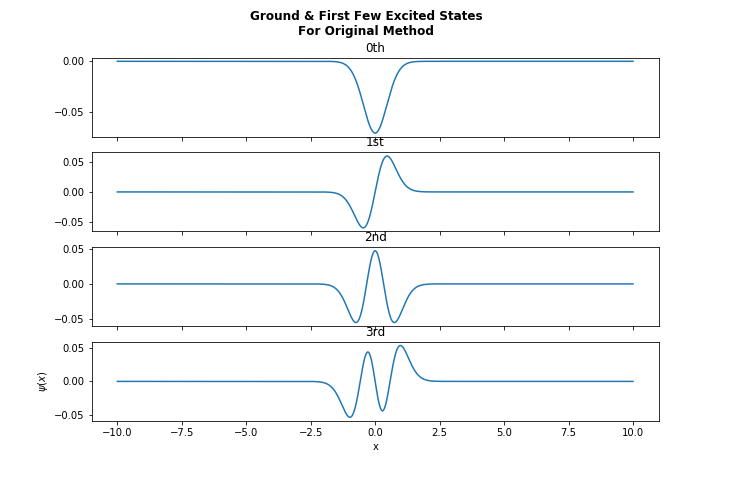

<IPython.core.display.Javascript object>


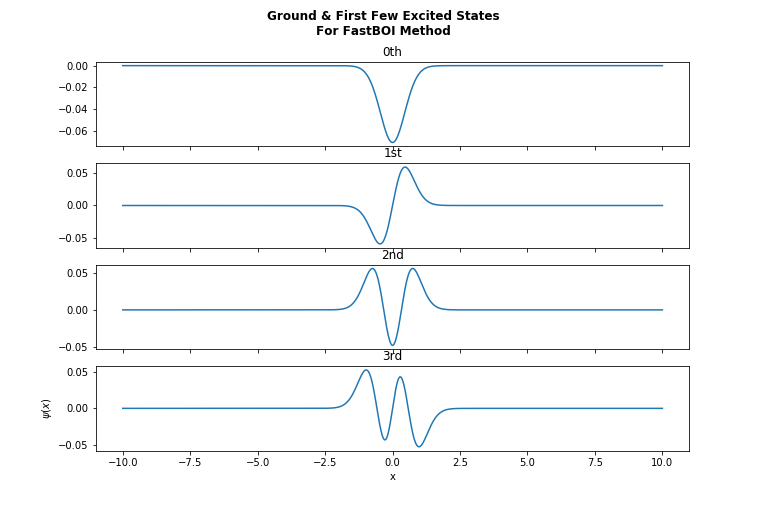

Text(0.5, 0.98, 'Ground & First Few Excited States\nFor FastBOI Method')

In [44]:
import matplotlib.pyplot as plt
%matplotlib notebook

fig, [ax1,ax2,ax3,ax4] = plt.subplots(4,1, sharex=True)
ax = [ax1,ax2,ax3,ax4]
suffixes = ['th','st','nd','rd']
t = 0
for i in range(4):
    ax[i].plot(x_test, eigvecs_original[:,i])
    ax[i].set_title('{}{}'.format(i,suffixes[i]))
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.suptitle('Ground & First Few Excited States\nFor Original Method', fontweight='bold')

fig2, [ax1,ax2,ax3,ax4] = plt.subplots(4,1, sharex=True)
ax = [ax1,ax2,ax3,ax4]
suffixes = ['th','st','nd','rd']
t = 0
for i in range(4):
    ax[i].plot(x_test, eigvecs_fastboi[:,i])
    ax[i].set_title('{}{}'.format(i,suffixes[i]))
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.suptitle('Ground & First Few Excited States\nFor FastBOI Method', fontweight='bold')


## Efficiency Comparisons:

#### 1: Ground State only, 50k grid points, 1 boosting stage (factor = 100x)

In [54]:
import timeit
x_full = np.linspace(-10,10,50000)
H_full = gen_diag_Hamiltonian(x_full) + gen_diag_V(x_full, potential, 0)

%timeit -r 1 eigsh(H_full, k=1, sigma=-100000)

42.2 s ± 5.14 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%timeit fastboi(x_full, potential, 100, 1, -100000, 1)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


464 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 2: Ground State only, 50k grid points, 1 boosting stage (factor = 1000x)

In [60]:
%timeit fastboi(x_full, potential, 1000, 1, -100000, 1)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


391 ms ± 6.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 3: Ground State only, 50k grid points, 2 boosting stages (factor = 30x)

In [59]:
%timeit fastboi(x_full, potential, 30, 2, -100000, 1)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


411 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 4: Ground State only, 500k grid points, 1 boosting stage (factor = 1000x)

In [6]:
x_full = np.linspace(-10,10,500000)
H_full = gen_diag_Hamiltonian(x_full) + gen_diag_V(x_full, potential, 0)

%timeit -r 1 eigsh(H_full, k=1, sigma=-100000)

In [7]:
%timeit fastboi(x_full, potential, 100, 1, -100000, 1)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


5.16 s ± 270 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
%timeit fastboi(x_full, potential, 1000, 1, -100000, 1)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


3.91 s ± 254 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 5: Ground State only, 500k grid points, 2 boosting stages (factor = 100x)

In [72]:
%timeit fastboi(x_full, potential, 100, 2, -100000, 1)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


3.49 s ± 93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 6: Ground State only, 5M grid points, 1 boosting stage (factor = 1000x)

* Note: at this model size there is no point comparing it to the original model, instead linear scaling is assumed,
  corresponding to ~50mins for the original

In [ ]:
x_full = np.linspace(-10,10,5000000)

%timeit -r 1 fastboi(x_full, potential, 1000, 1, -100000, 1)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


#### 7: Ground State only, 5M grid points, 2 boosting stages (factor = 250x)

In [77]:
%timeit -r 1 fastboi(x_full, potential, 250, 2, -100000, 1)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


35.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### 8: Ground State only, 5M grid points, 3 boosting stages (factor = 40x)

In [80]:
%timeit -r 1 fastboi(x_full, potential, 40, 3, -100000, 1)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


36.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### 9: Ground State only, 5M grid points, 4 boosting stages (factor = 10x)

In [81]:
%timeit -r 1 fastboi(x_full, potential, 10, 4, -100000, 1)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


39.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### 10: GS only, 5M grid pts, 5 eigstates

In [11]:
x_full = np.linspace(-10,10,5000000)

%timeit -r 1 fastboi(x_full, potential, 1000, 1, -100000, 1)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


MemoryError: 

In [ ]:
%timeit -r 1 fastboi(x_full, potential, 1000, 1, -100000, 1)